In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

import seaborn as sns
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

2023-03-07 16:38:53.166418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 16:38:55.413062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 16:38:55.413184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-07 16:38:55.413195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

## Load the new CMAPPS data

In [2]:
mypath = 'N-CMAPSS_DL/N-CMAPSS/Samples_whole/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

train_units = [2,5,10,16,18,20]
test_units = [11,14,15]

test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
train_files = list(set(onlyfiles) - set(test_files))

['Unit5_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit11_win1_str1_smp500.npz', 'Unit14_win1_str1_smp500.npz', 'Unit15_win1_str1_smp500.npz']


## Make Input-Output for training the UQ models

In [3]:
def load_part_array_merge (current_dir, npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(current_dir + npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

In [4]:
Xtrain_norm,Ytrain = load_part_array_merge(mypath,train_files)
Xtest_norm,Ytest = load_part_array_merge(mypath,test_files)
Xtrain_norm = Xtrain_norm[:,0,:]
Xtest_norm = Xtest_norm[:,0,:]
Ytrain_norm = (Ytrain)/np.max(Ytrain)
Ytest_norm = (Ytest)/np.max(Ytrain)

In [5]:
test_units = [11]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest11_norm,Ytest11 = load_part_array_merge(mypath,test_files)
Xtest11_norm = Xtest11_norm[:,0,:]
Ytest11_norm = np.expand_dims((Ytest11)/np.max(Ytrain),1)


test_units = [14]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest14_norm,Ytest14 = load_part_array_merge(mypath,test_files)
Xtest14_norm = Xtest14_norm[:,0,:]
Ytest14_norm = np.expand_dims((Ytest14)/np.max(Ytrain),1)


test_units = [15]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest15_norm,Ytest15 = load_part_array_merge(mypath,test_files)
Xtest15_norm = Xtest15_norm[:,0,:]
Ytest15_norm = np.expand_dims((Ytest15)/np.max(Ytrain),1)

## Utils

In [6]:
# Ensembling of individual models
def get_ensemble(pred_df, UQmodelcode, nmodels_select):
    """
    Input
    pred_df - dataframe with individual model predictions
              Columns named as "NN_mu_#ofmodel" and "NN_sigma_#ofmodel"
    UQmodelcode - 'NN' for neural network ensemble, 'MC' for MC dropout
    nmodels_select - number of individual models to form the ensemble
    """
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = pred_df[mu_cols].mean(axis=1)
    if UQmodelcode=="NN":
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             + np.mean(pred_df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC": # no sigma_cols for individual models
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    pred_df[UQmodelcode+"_mu_eff"] = mu_eff
    pred_df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return pred_df
    
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    """
    Input: 
    y_true - true values
    mu     - predicted mean
    sigma  - predicted standard deviation
    
    Output:
    exp_CIs - expected confidence
    pred_CIs - predicted confidence
    """
    exp_CIs = np.linspace(1e-10, 1-1e-10, 1000) #expected CIs
    pred_CIs=[]                                 #predicted CIs
    for exp_CI in sorted(exp_CIs):
        intervals = scipy.stats.norm.interval(exp_CI, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        pred_CIs.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    ECE = np.mean(np.abs(exp_CIs - pred_CIs))
    return 100*exp_CIs, 100*np.array(pred_CIs), 100*ECE  # converting to percentages

def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

def get_nll(y_true, y_pred, s_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    s_pred - predicted standard deviation
    Outputs:
    median of NLL
    """
    return np.mean(np.log(s_pred**2)/2 + 
                     np.divide((y_true - y_pred)**2, 2* s_pred**2))

## Uncertainty Model 1: Deep Ensemble (DE)

In [7]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(variance):
    def nll_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((variance)) + 
                              0.5*tf.math.divide(tf.math.square(y_true - y_pred), variance)) + 1e-6
    return nll_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [8]:
def generate_trained_NNmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    get_gl_function - Gaussian layer outputs as function 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    for _ in range(num_res_layers):
        x  = Dense(50, activation = actfn)(x)
        x1 = Dense(50, activation = actfn)(x)
        x = x1 + x
    x = Dense(10, activation = actfn)(x)
      
    mu, variance = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(variance), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 1)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_gl_function = K.function(inputs=[model.input], 
                                  outputs=model.get_layer(layer_name).output)
    return get_gl_function

In [9]:
# First let us do a single run
prediction_fns, train_rmse = [], []
nmodels = 1    
nep = 50

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_NNmodel(Xtrain_norm, Ytrain_norm, nepochs = nep, actfn = 'relu')
    train_rmse.append(get_rmse(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    
nmodels_select = 1  # select these # of models
final_NN_fns = []
for i in range(nmodels_select):
    final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])

Train on 10527 samples
Epoch 1/50


2023-03-07 16:39:03.743795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-07 16:39:03.744983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-07 16:39:03.745017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-07 16:39:03.745670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI

10527/10527 [==============================] - 1s 114us/sample - loss: -0.9299
Epoch 2/50
10527/10527 [==============================] - 1s 60us/sample - loss: -1.5476
Epoch 3/50
10527/10527 [==============================] - 1s 64us/sample - loss: -1.7918
Epoch 4/50
10527/10527 [==============================] - 1s 63us/sample - loss: -1.8758
Epoch 5/50
10527/10527 [==============================] - 1s 61us/sample - loss: -1.9011
Epoch 6/50
10527/10527 [==============================] - 1s 62us/sample - loss: -1.8940
Epoch 7/50
10527/10527 [==============================] - 1s 62us/sample - loss: -2.0244
Epoch 8/50
10527/10527 [==============================] - 1s 61us/sample - loss: -2.0478
Epoch 9/50
10527/10527 [==============================] - 1s 62us/sample - loss: -2.0764
Epoch 10/50
10527/10527 [==============================] - 1s 62us/sample - loss: -2.0882
Epoch 11/50
10527/10527 [==============================] - 1s 62us/sample - loss: -2.1243
Epoch 12/50
10527/10527 [====

2023-03-07 16:39:36.642124: W tensorflow/c/c_api.cc:291] Operation '{name:'main_output/add' id:204 op device:{requested: '', assigned: ''} def:{{{node main_output/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](main_output/MatMul, main_output/add/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
100% |##########################################################################################################################|


In [10]:
select_modelDE = prediction_fns[np.argmin(train_rmse)]
print("Train MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtrain_norm)[0]))[:,0]*np.max(Ytrain), Ytrain))
print("Test11 MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest11_norm)[0]))[:,0]*np.max(Ytrain), Ytest11))
print("Test14 MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest14_norm)[0]))[:,0]*(np.max(Ytrain)), Ytest14))
print("Test15 MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest15_norm)[0]))[:,0]*(np.max(Ytrain)), Ytest15))
print("Test MAE: ", get_rmse(np.array(K.get_value(select_modelDE(Xtest_norm)[0]))[:,0]*(np.max(Ytrain)), Ytest))

Train MAE:  7.465525
Test11 MAE:  8.859139
Test14 MAE:  7.533733
Test15 MAE:  5.506976
Test MAE:  7.688716


In [11]:
model_train_bool = False
dataset = ['train', 'test', 'test11', 'test14', 'test15']

if model_train_bool:
    niter = 10 # Multiple runs
    nepochs = 100
    nmodels = 10 # train models for each iteration
    nmodels_select = 6 # select top models based on training rmse

    allCI_NN = np.zeros((1000, niter))
    pbar=ProgressBar()

    allresults_NNdf = pd.DataFrame()
    for myiter in pbar(range(niter)):
        prediction_fns=[]
        train_rmse=[]
        for i in range(nmodels):
            my_func = generate_trained_NNmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
            train_rmse.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
            prediction_fns.append(my_func)

        
        final_NN_fns = []
        for i in range(nmodels_select):
            final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])


        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nmodels_select):
                result_df["NN_mu_"+str(i)] = (final_NN_fns[i](Xnorm)[0])*np.max(Ytrain)
                result_df["NN_sigma_"+str(i)] = (np.sqrt(final_NN_fns[i](Xnorm)[1]))*np.max(Ytrain)

            result_df = get_ensemble(result_df, "NN", nmodels_select)
            result_df['iteration'] = myiter
            allresults_NNdf = pd.concat([allresults_NNdf, result_df], axis = 0)
    allresults_NNdf.to_excel("results/NNEnsemble_CMAPPS_prediction_results_resnet.xlsx")  
else:
    allresults_NNdf=pd.read_excel("results/NNEnsemble_CMAPPS_prediction_results_resnet.xlsx") 


## Results - Visualization

11.621293308431282


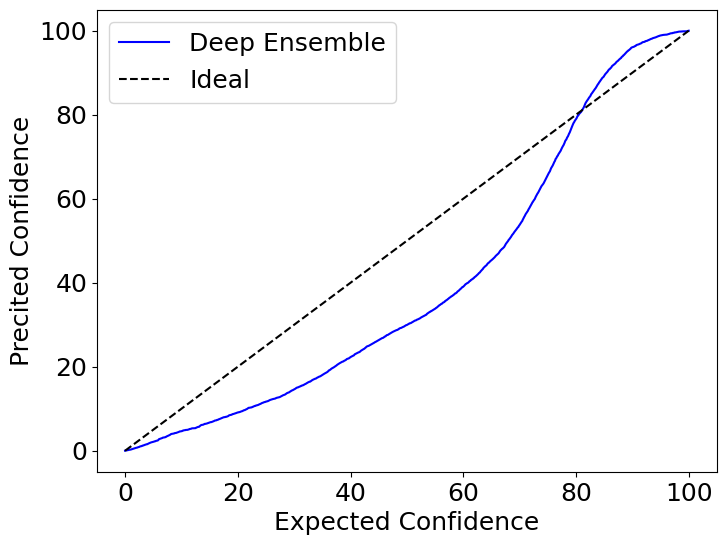

In [13]:
allresults_NNdf_sorted = allresults_NNdf.loc[allresults_NNdf['dataset']=='test11']
allresults_NNdf_sorted = allresults_NNdf_sorted.sort_values(by='True', ascending=True)

alphas, CI_DE,ECE = get_confidence_interval(allresults_NNdf_sorted['True'].values, 
                                       allresults_NNdf_sorted['NN_mu_eff'].values, 
                                       allresults_NNdf_sorted['NN_sigma_eff'].values)

print(ECE)


fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='Deep Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()


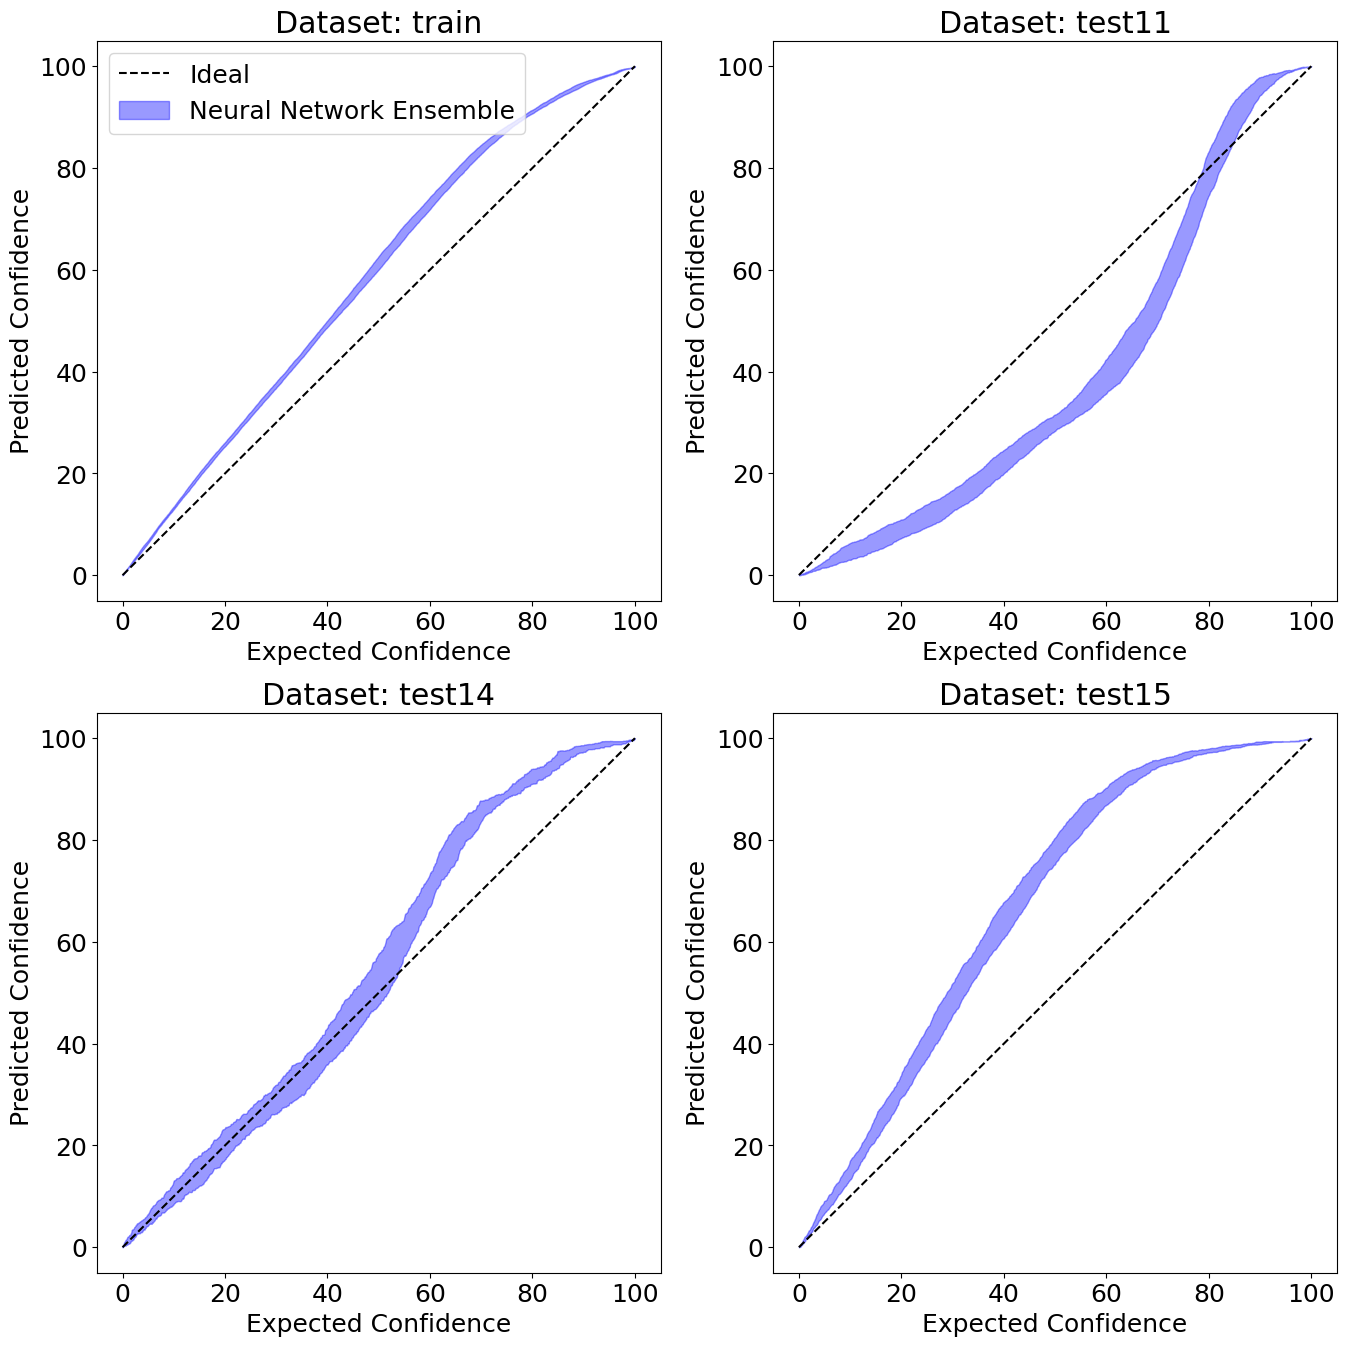

In [14]:
# plot calibration curve

dataset = ['train','test11', 'test14', 'test15']

niter = len(set(allresults_NNdf['iteration']))
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_NN = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_NNdf.loc[(allresults_NNdf['dataset']==dataset[myset]) & 
                                 (allresults_NNdf['iteration']==myiter)]
        exp_CI, CI_NN, ECE  = get_confidence_interval(df['True'].values, 
                                               df['NN_mu_eff'].values, 
                                               df['NN_sigma_eff'].values)
        allCI_NN[:,myiter] = CI_NN
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(exp_CI,
                np.mean(allCI_NN, axis = 1)+np.std(allCI_NN, axis = 1),
                np.mean(allCI_NN, axis = 1)-np.std(allCI_NN, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Neural Network Ensemble')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

## UQ Model: MC Dropout

In [25]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    model - MC Dropout model 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = 0.10)(x)
    for _ in range(num_res_layers):
        x  = Dense(50, activation = actfn)(x)
        x1 = Dense(50, activation = actfn)(x)
        x = x1 + x
        x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)
    #optimizer = Adam(learning_rate = 0.0004)
    model = Model(feature_input, mu)
    #model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 1)

    return model

In [26]:
nmodels = 1 # train models and select the best out of these
nep = 400
all_models_MC=[]
all_rmse_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, nep, 'relu')
    all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)


Train on 10527 samples
Epoch 1/100


2023-03-07 16:52:16.671729: W tensorflow/c/c_api.cc:291] Operation '{name:'training_12/Adam/dense_38/bias/v/Assign' id:27549 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_38/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_38/bias/v, training_12/Adam/dense_38/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


10527/10527 [==============================] - 4s 391us/sample - loss: 0.0855
Epoch 2/100
10527/10527 [==============================] - 1s 87us/sample - loss: 0.0561
Epoch 3/100
10527/10527 [==============================] - 1s 83us/sample - loss: 0.0292
Epoch 4/100
10527/10527 [==============================] - 1s 82us/sample - loss: 0.0219
Epoch 5/100
10527/10527 [==============================] - 1s 85us/sample - loss: 0.0191
Epoch 6/100
10527/10527 [==============================] - 1s 84us/sample - loss: 0.0181
Epoch 7/100
10527/10527 [==============================] - 1s 85us/sample - loss: 0.0164
Epoch 8/100
10527/10527 [==============================] - 1s 86us/sample - loss: 0.0161
Epoch 9/100
10527/10527 [==============================] - 1s 85us/sample - loss: 0.0156
Epoch 10/100
10527/10527 [==============================] - 1s 87us/sample - loss: 0.0155
Epoch 11/100
10527/10527 [==============================] - 1s 84us/sample - loss: 0.0148
Epoch 12/100
10527/10527 [====

100% |##########################################################################################################################|


In [27]:
select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)]
print("Train MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtrain_norm)))[:,0]*(np.max(Ytrain)), Ytrain))
print("Test11 MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest11_norm)))[:,0]*(np.max(Ytrain)), Ytest11))
print("Test14 MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest14_norm)))[:,0]*(np.max(Ytrain)), Ytest14))
print("Test15 MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest15_norm)))[:,0]*(np.max(Ytrain)), Ytest15))
print("Test MAE: ", get_rmse(np.array(K.get_value(select_modelMC(Xtest_norm)))[:,0]*(np.max(Ytrain)), Ytest))

Train MAE:  10.537809
Test11 MAE:  13.02519
Test14 MAE:  11.476126
Test15 MAE:  10.174462
Test MAE:  11.918095


In [28]:
model_train_bool = True
nmodels = 1 # total models trained and best one picked
nensemble_size = 20 # run these many times per each select model with dropout
niter = 10
if model_train_bool:


    allCI_MC = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_MCdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_MC=[]
        all_rmse_train_MC = np.zeros(nmodels,)
        pbar = ProgressBar()
        for i in range(nmodels): # train multiple models to select the best
            model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, nep, 'relu')
            all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
            all_models_MC.append(model_MC)

        select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)] # best model

        for myset in dataset: # execute the model for all the datasets
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in tqdm(range(nensemble_size)): # run the best model multiple times with dropout enabled
                result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

            result_df['iteration'] = myiter
            allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
        allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nensemble_size)
    allresults_MCdf.to_excel("results/MCDropout_CMAPPS_prediction_results_resnet.xlsx")  
else:
    allresults_MCdf=pd.read_excel("results/MCDropout_CMAPPS_prediction_results_resnet.xlsx")  

Train on 10527 samples
Epoch 1/100


2023-03-07 16:53:57.919514: W tensorflow/c/c_api.cc:291] Operation '{name:'training_14/Adam/dense_46/bias/m/Assign' id:28453 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/dense_46/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/dense_46/bias/m, training_14/Adam/dense_46/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


10527/10527 [==============================] - 4s 367us/sample - loss: 0.0776
Epoch 2/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0485
Epoch 3/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0275
Epoch 4/100
10527/10527 [==============================] - 1s 88us/sample - loss: 0.0208
Epoch 5/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0192
Epoch 6/100
10527/10527 [==============================] - 1s 87us/sample - loss: 0.0177
Epoch 7/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0162
Epoch 8/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0155
Epoch 9/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0151
Epoch 10/100
10527/10527 [==============================] - 1s 88us/sample - loss: 0.0146
Epoch 11/100
10527/10527 [==============================] - 1s 87us/sample - loss: 0.0152
Epoch 12/100
10527/10527 [====

2023-03-07 16:55:34.417338: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_49/bias/Assign' id:28741 op device:{requested: '', assigned: ''} def:{{{node dense_49/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_49/bias, dense_49/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


10527/10527 [==============================] - 4s 374us/sample - loss: 0.0760
Epoch 2/100
10527/10527 [==============================] - 1s 91us/sample - loss: 0.0518
Epoch 3/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0276
Epoch 4/100
10527/10527 [==============================] - 1s 88us/sample - loss: 0.0218
Epoch 5/100
10527/10527 [==============================] - 1s 88us/sample - loss: 0.0193
Epoch 6/100
10527/10527 [==============================] - 1s 86us/sample - loss: 0.0175
Epoch 7/100
10527/10527 [==============================] - 1s 87us/sample - loss: 0.0172
Epoch 8/100
10527/10527 [==============================] - 1s 86us/sample - loss: 0.0160
Epoch 9/100
10527/10527 [==============================] - 1s 87us/sample - loss: 0.0155
Epoch 10/100
10527/10527 [==============================] - 1s 86us/sample - loss: 0.0152
Epoch 11/100
10527/10527 [==============================] - 1s 87us/sample - loss: 0.0152
Epoch 12/100
10527/10527 [====

100%|████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.70s/it]


Train on 10527 samples
Epoch 1/100


2023-03-07 16:59:54.434672: W tensorflow/c/c_api.cc:291] Operation '{name:'training_18/Adam/dense_56/kernel/m/Assign' id:35424 op device:{requested: '', assigned: ''} def:{{{node training_18/Adam/dense_56/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_18/Adam/dense_56/kernel/m, training_18/Adam/dense_56/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


10527/10527 [==============================] - 5s 487us/sample - loss: 0.0789
Epoch 2/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0481
Epoch 3/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0270
Epoch 4/100
10527/10527 [==============================] - 1s 88us/sample - loss: 0.0215
Epoch 5/100
10527/10527 [==============================] - 1s 85us/sample - loss: 0.0193
Epoch 6/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0183
Epoch 7/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0173
Epoch 8/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0164
Epoch 9/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0155
Epoch 10/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0158
Epoch 11/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0148
Epoch 12/100
10527/10527 [====

2023-03-07 17:01:35.461167: W tensorflow/c/c_api.cc:291] Operation '{name:'training_20/Adam/dense_64/bias/m/Assign' id:36103 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_64/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_64/bias/m, training_20/Adam/dense_64/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


10527/10527 [==============================] - 5s 448us/sample - loss: 0.0833
Epoch 2/100
10527/10527 [==============================] - 1s 92us/sample - loss: 0.0608
Epoch 3/100
10527/10527 [==============================] - 1s 92us/sample - loss: 0.0302
Epoch 4/100
10527/10527 [==============================] - 1s 92us/sample - loss: 0.0233
Epoch 5/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0210
Epoch 6/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0195
Epoch 7/100
10527/10527 [==============================] - 1s 93us/sample - loss: 0.0188
Epoch 8/100
10527/10527 [==============================] - 1s 95us/sample - loss: 0.0171
Epoch 9/100
10527/10527 [==============================] - 1s 92us/sample - loss: 0.0162
Epoch 10/100
10527/10527 [==============================] - 1s 89us/sample - loss: 0.0170
Epoch 11/100
10527/10527 [==============================] - 1s 90us/sample - loss: 0.0159
Epoch 12/100
10527/10527 [====

100%|████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:53<00:00,  2.14s/it]
100% |##########################################################################################################################|


## Results - Visualization

/local/home/lbiggio/UQ_ML_Review/UQ/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/local/home/lbiggio/UQ_ML_Review/UQ/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


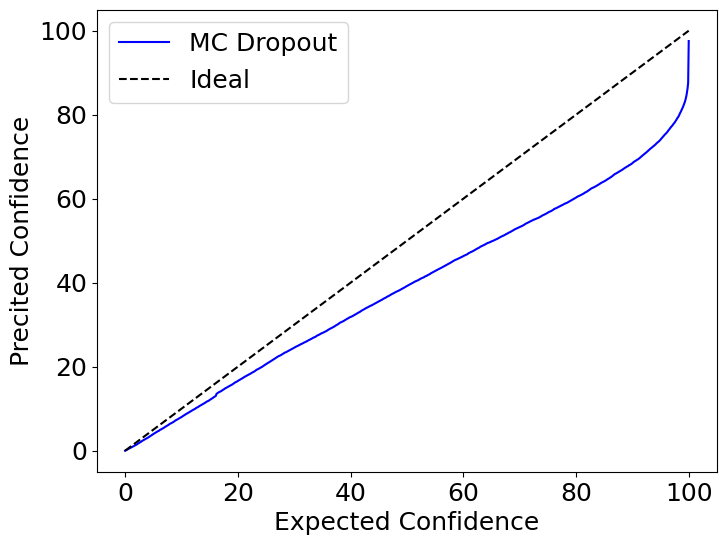

In [31]:
dataset_='train'
allresults_MCdf_ = allresults_MCdf[allresults_MCdf['dataset']==dataset_].sort_values(by='True', ascending=True)

alphas, CI_DE,_ = get_confidence_interval(allresults_MCdf_['True'].values, 
                                       allresults_MCdf_['MC_mu_eff'].values, 
                                       allresults_MCdf_['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()